# Staging AGN and Checking Distribution

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2 as cv

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

import numpy as np
from scipy import special
from scipy.stats import kstwobign, anderson
import scipy.stats.distributions as dist


plt.rcParams['font.size'] = 14

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing Data

In [3]:
agn_cat = pd.read_csv(f'{combine_fold}/source-agn-cat.csv', index_col = 0)

In [4]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [6]:
agn_cat.head()

,ID,agn_clsf
0,765389,SFG
1,715417,HLAGN
2,1485262,SFG
3,998663,HLAGN
0,888234,AGN


In [7]:
len(agn_cat)

1362

In [8]:
df_cat_red = df_cat[['ORyanID_23', 'lp_mass_best', 'ez_sfr', 'ID', 'category']]

In [9]:
df_merg = (
    df_cat_red
    .merge(agn_cat, on = 'ID', how = 'left')
)

### The Raw Numbers

In [10]:
print(df_merg.agn_clsf.value_counts())

SFG      828
AGN      532
HLAGN      2
Name: agn_clsf, dtype: int64


In [11]:
def agn_class(x):
    if str(x) == 'SFG' or str(x) == 'SF':
        return 'SFG'
    elif str(x) == 'AGN' or str(x) == 'HLAGN':
        return 'AGN'
    else:
        return 'unknown'

In [12]:
df_agn_simp = (
    df_merg
    .assign(agn = df_merg.agn_clsf.apply(lambda x: agn_class(x)))
)

In [13]:
df_agn_simp.agn.value_counts()

unknown    2819
SFG         828
AGN         534
Name: agn, dtype: int64

In [14]:
for i in range(4):
    stage = f'stage{i+1}'
    df_tmp = df_agn_simp.query('category == @stage')
    print(f'Stage {i+1}')
    print(df_tmp.agn.value_counts())
    print(' ')

Stage 1
unknown    620
SFG        128
AGN        110
Name: agn, dtype: int64
 
Stage 2
unknown    714
SFG        194
AGN        135
Name: agn, dtype: int64
 
Stage 3
unknown    1024
SFG         315
AGN         186
Name: agn, dtype: int64
 
Stage 4
unknown    461
SFG        191
AGN        103
Name: agn, dtype: int64
 


In [15]:
for i in range(4):
    stage = f'stage{i+1}'
    df_tmp = df_agn_simp.query('category == @stage')
    print(f'Stage {i+1}')
    print(df_tmp.agn.value_counts()['AGN'] / (df_tmp.agn.value_counts().sum()))
    print(' ')

Stage 1
0.1282051282051282
 
Stage 2
0.12943432406519656
 
Stage 3
0.1219672131147541
 
Stage 4
0.13642384105960265
 


### Plotting

In [16]:
df_agn_clsf = df_agn_simp[['ID','agn']]

In [17]:
df_agn_clsf.agn.value_counts()

unknown    2819
SFG         828
AGN         534
Name: agn, dtype: int64

In [18]:
df_agn_id_merg = (
    df_agn_clsf
    .merge(df_cat[['ID', 'lp_mass_best', 'ez_sfr', 'category']], on = 'ID', how = 'right')
    .query('lp_mass_best > 9.25')
)
df_agn_id_merg

,ID,agn,lp_mass_best,ez_sfr,category
0,816891,unknown,9.28590,0.589695,stage4
1,860686,unknown,10.44862,1.609304,stage3
3,1304538,unknown,9.96798,1.101499,stage3
4,1310001,unknown,10.41827,1.083541,stage3
5,1308927,unknown,10.03523,1.198906,stage3
...,...,...,...,...,...
4176,1520733,unknown,9.27097,0.369745,stage4
4177,1520749,unknown,9.50357,0.507741,stage2
4178,1523385,unknown,9.53909,0.406027,stage3
4179,1524909,SFG,9.76084,0.637714,stage3


In [19]:
def get_clsf(x):
    if x == 'HLAGN' or x == 'MLAGN':
        return 'AGN'
    elif type(x) == str:
        return x
    elif np.isnan(x):
        return 'Unknown'
    else:
        print('Error')
        sys.exit()

In [20]:
df_reclsf = (
    df_agn_id_merg
    .assign(agn_clsf_uk = df_agn_id_merg.agn.apply(lambda x: get_clsf(x)))
    .query('ez_sfr < 5.5')
)

In [21]:
df_reclsf.agn_clsf_uk.value_counts()

unknown    2218
SFG         732
AGN         454
Name: agn_clsf_uk, dtype: int64

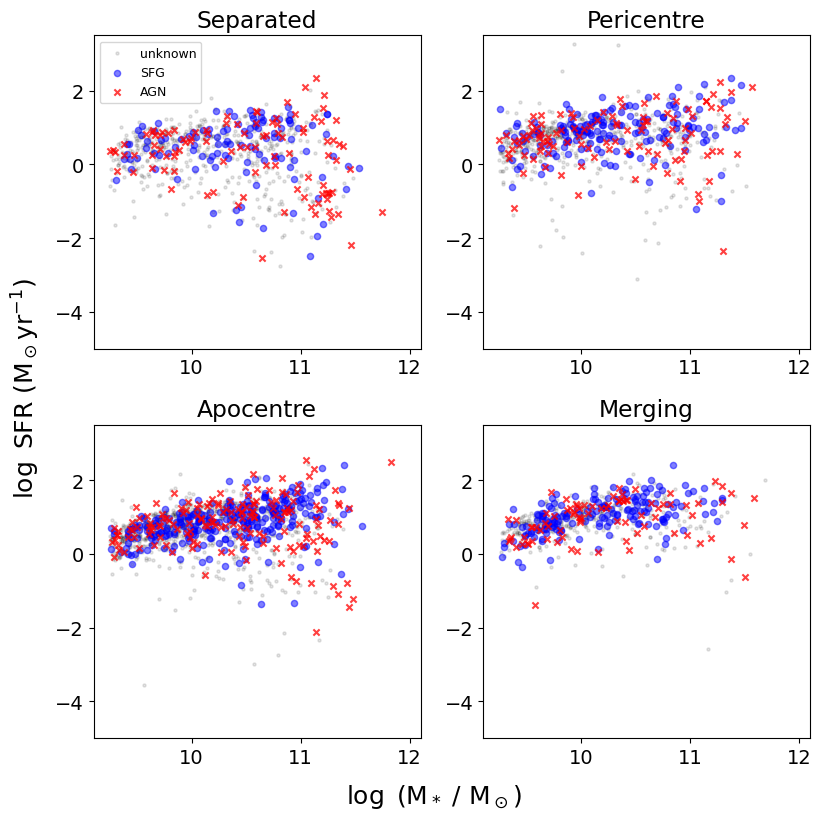

In [23]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
alphas = [0.1, 0.5, 0.75]
markers = ['.', 'o', 'x']
agn_clsf = ['unknown','SFG','AGN']
colours = ['black', 'blue', 'red']
stage_list = ['Separated','Pericentre','Apocentre','Merging']
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_reclsf.query('category == @stage')
        for k, clsf in enumerate(agn_clsf):
            df = df_stage.query('agn_clsf_uk == @clsf')

            ax[i,j].scatter(np.array(df.lp_mass_best), np.array(df.ez_sfr), color = colours[k], marker = markers[k], s = 20, alpha = alphas[k])
            ax[i,j].set_title(f'{stage_list[counter-1]}')
            ax[i,j].set_xlim([9.1, 12.1])
            ax[i,j].set_ylim([-5,3.5])
        
        counter += 1
ax[0,0].legend(agn_clsf, loc = 'upper left', fontsize = 9)
fig.text(0.5, -0.01, '$\log$ (M$_*$ / M$_\odot$)', ha='center', va='center', fontsize = 18)
fig.text(-0.01, 0.5, '$\log$ SFR (M$_\odot$yr$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fig_folder}/agn-stage-dist.pdf', bbox_inches = 'tight')
plt.show()

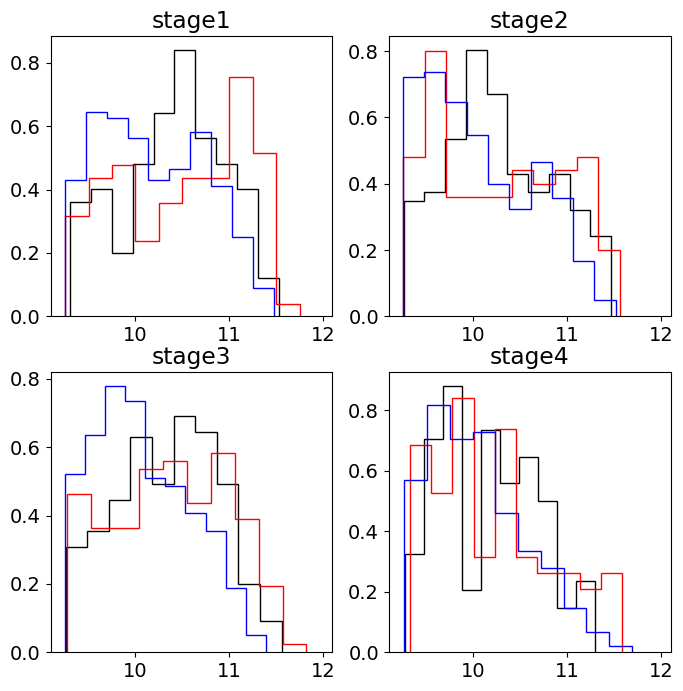

In [24]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_reclsf.query('category == @stage')
        df_agn = df_stage.query('agn_clsf_uk == "AGN"')
        df_sf = df_stage.query('agn_clsf_uk == "SFG"')
        df_unknown = df_stage.query('agn_clsf_uk == "unknown"')
        
        ax[i,j].hist(np.array(df_sf.lp_mass_best), color = 'black', histtype='step', density = True, bins = 10)#, alpha = 0.75)
        ax[i,j].hist(np.array(df_agn.lp_mass_best), color = 'red', histtype='step', density = True, bins = 10)#, alpha = 0.75)
        ax[i,j].hist(np.array(df_unknown.lp_mass_best), color = 'blue', histtype='step', density = True, bins = 10)#, alpha = 0.75)
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([9.1, 12.1])
        
        counter += 1

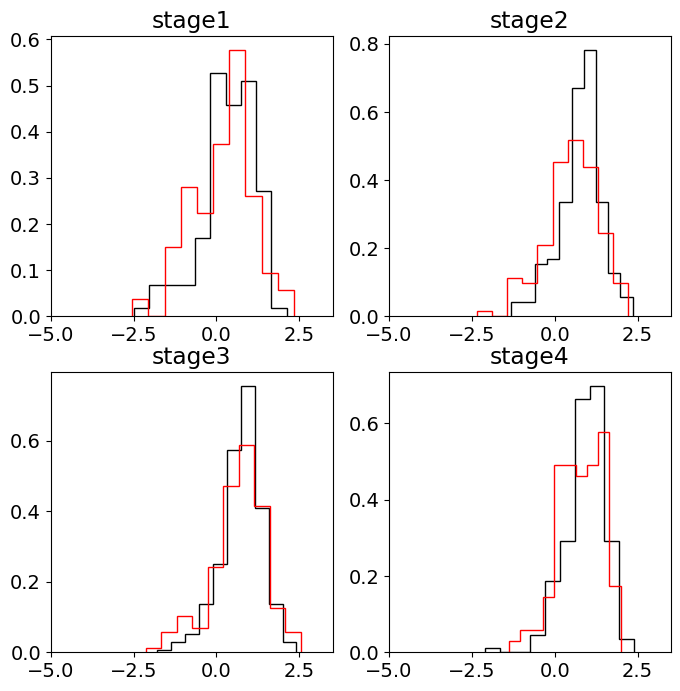

In [25]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_agn_simp.query('category == @stage')
        df_agn = df_stage.query('agn == "AGN"')
        df_sf = df_stage.query('agn == "SFG"')
        
        ax[i,j].hist(np.array(df_sf.ez_sfr), color = 'black', histtype='step', bins = 10, density = True)#, alpha = 0.75)
        ax[i,j].hist(np.array(df_agn.ez_sfr), color = 'red', histtype='step', bins = 10, density = True)#, alpha = 0.75)
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([-5, 3.5])
        
        counter += 1

So, galaxies with lower SF gain AGN as we go to higher stages. This is an interesting result! And points to interaction definitively having an impact on AGN, but only as coalescence approaches. So, how do we prove this / make sure it's not due to selection effects?

### Aird et al. 2019 Classification with AGN

In [26]:
df_red_tmp = df_cat.query('lp_mass_best > 9.25 and lp_mass_best < 12.5')
df_red = df_red_tmp.query('ez_sfr > -5 and ez_sfr < 3.5')

In [27]:
df_sfrs = df_red[['ID', 'category', 'ez_sfr', 'lp_mass_best', 'ez_z_phot', 'lp_zBEST']]

In [28]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [29]:
df_z = (
    df_sfrs
    .assign(redshift = df_sfrs.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
    .drop(columns = ['ez_z_phot', 'lp_zBEST'])
)

In [30]:
df_ms_sfr = (
    df_z
    .assign(ms_sfr = df_z.apply(lambda row: -7.6 + (0.76 * row.lp_mass_best) + 2.95 * np.log10(1 + row.redshift), axis = 1))
)

In [31]:
df_ms_sfr

,ID,category,ez_sfr,lp_mass_best,redshift,ms_sfr
0,816891,stage4,0.589695,9.28590,0.519525,-0.006678
1,860686,stage3,1.609304,10.44862,1.124400,1.306298
3,1304538,stage3,1.101499,9.96798,1.024009,0.878992
4,1310001,stage3,1.083541,10.41827,0.486400,0.825686
5,1308927,stage3,1.198906,10.03523,0.695800,0.703430
...,...,...,...,...,...,...
4176,1520733,stage4,0.369745,9.27097,0.484922,-0.047537
4177,1520749,stage2,0.507741,9.50357,0.647512,0.262358
4178,1523385,stage3,0.406027,9.53909,0.301645,-0.012538
4179,1524909,stage3,0.637714,9.76084,0.855695,0.610333


In [32]:
def finding_sfr(log_sfr, log_sfr_ms):
    sfr = 10 ** log_sfr
    sfr_ms = 10 ** log_sfr_ms
    frac = sfr / sfr_ms
    return np.log10(frac)

In [33]:
df_comp = (
    df_ms_sfr
    .assign(sfr_sfr_ms = df_ms_sfr.apply(lambda row: finding_sfr(row.ez_sfr, row.ms_sfr), axis = 1))
)
df_comp

,ID,category,ez_sfr,lp_mass_best,redshift,ms_sfr,sfr_sfr_ms
0,816891,stage4,0.589695,9.28590,0.519525,-0.006678,0.596373
1,860686,stage3,1.609304,10.44862,1.124400,1.306298,0.303006
3,1304538,stage3,1.101499,9.96798,1.024009,0.878992,0.222507
4,1310001,stage3,1.083541,10.41827,0.486400,0.825686,0.257855
5,1308927,stage3,1.198906,10.03523,0.695800,0.703430,0.495476
...,...,...,...,...,...,...,...
4176,1520733,stage4,0.369745,9.27097,0.484922,-0.047537,0.417282
4177,1520749,stage2,0.507741,9.50357,0.647512,0.262358,0.245383
4178,1523385,stage3,0.406027,9.53909,0.301645,-0.012538,0.418565
4179,1524909,stage3,0.637714,9.76084,0.855695,0.610333,0.027381


In [34]:
df_reclsf.head()

,ID,agn,lp_mass_best,ez_sfr,category,agn_clsf_uk
0,816891,unknown,9.28590,0.589695,stage4,unknown
1,860686,unknown,10.44862,1.609304,stage3,unknown
3,1304538,unknown,9.96798,1.101499,stage3,unknown
4,1310001,unknown,10.41827,1.083541,stage3,unknown
5,1308927,unknown,10.03523,1.198906,stage3,unknown


In [35]:
df_comp_agn = (
    df_comp
    .merge(df_reclsf[['ID', 'agn_clsf_uk']], on = 'ID', how = 'right')
)

In [36]:
df_comp_agn.head()

,ID,category,ez_sfr,lp_mass_best,redshift,ms_sfr,sfr_sfr_ms,agn_clsf_uk
0,816891,stage4,0.589695,9.28590,0.519525,-0.006678,0.596373,unknown
1,860686,stage3,1.609304,10.44862,1.124400,1.306298,0.303006,unknown
2,1304538,stage3,1.101499,9.96798,1.024009,0.878992,0.222507,unknown
3,1310001,stage3,1.083541,10.41827,0.486400,0.825686,0.257855,unknown
4,1308927,stage3,1.198906,10.03523,0.695800,0.703430,0.495476,unknown


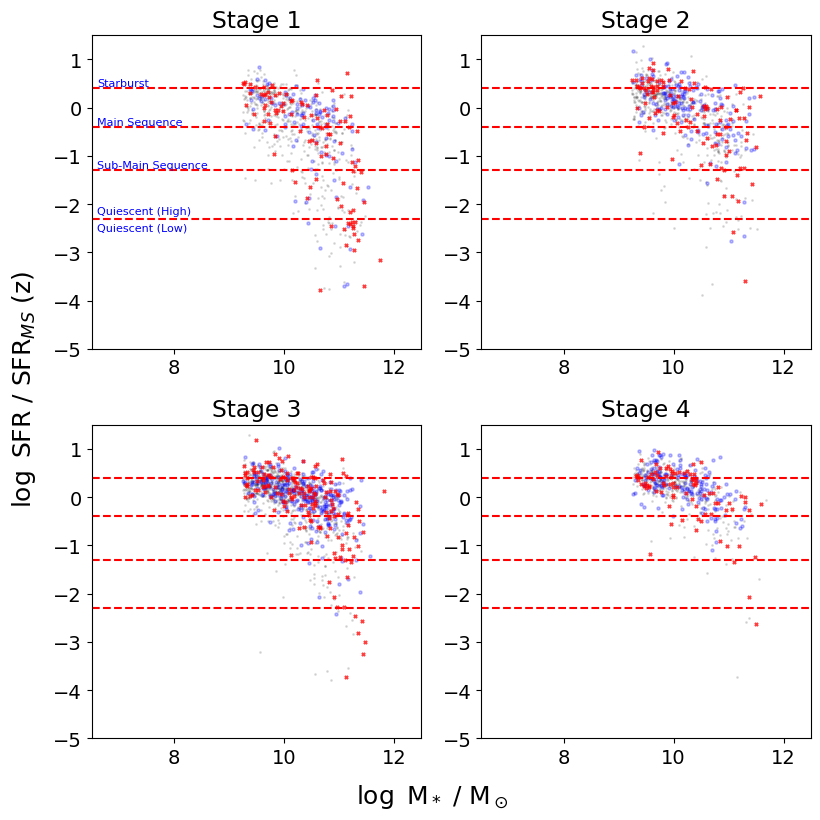

In [37]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
counter = 1
alphas = [0.1, 0.25, 0.75]
markers = ['.', 'o', 'x']
agn_clsf = ['unknown','SFG','AGN']
colours = ['black', 'blue', 'red']
for i in range(2):
    for j in range(2):
        for k, clsf in enumerate(agn_clsf):
            df_stage = df_comp_agn.query(f'category == "stage{counter}"')

            df_stage.query('agn_clsf_uk == @clsf').plot.scatter(
                x = 'lp_mass_best',
                y = 'sfr_sfr_ms',
                s = 5,
                marker = markers[k],
                alpha = alphas[k],
                color = colours[k],
                ax = ax[i,j],
                # figsize = (8,8),
                xlabel = '',
                ylabel = '',
                xlim = [6.5, 12.5],
                ylim = [-5, 1.5],
                fontsize = 14,
                title = f'Stage {counter}'
            )
        # x = np.array(df_comp.query(f'category == "stage{counter}"').lp_mass_best)
        # y = np.array(df_comp.query(f'category == "stage{counter}"').sfr_sfr_ms)
        # sns.kdeplot(x=x,y=y, ax=ax[i,j], thresh = 0.05, levels=8, color='blue')
        
        ax[i,j].axhline(0.4, color='red', linestyle='--')
        ax[i,j].axhline(-0.4, color = 'red', linestyle='--')
        ax[i,j].axhline(-1.3, color = 'red', linestyle = '--')
        ax[i,j].axhline(-2.3, color = 'red', linestyle='--')
        if counter == 1:
            ax[i,j].text(6.6, 0.45, 'Starburst', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -0.35, 'Main Sequence', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -1.25, 'Sub-Main Sequence', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -2.20, 'Quiescent (High)', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -2.55, 'Quiescent (Low)', fontsize = 8, color='blue')
        
        
        counter += 1
fig.text(0.5, -0.01, '$\log$ M$_*$ / M$_\odot$', ha='center', va='center', fontsize = 18)
fig.text(-0.01, 0.5, '$\log$ SFR / SFR$_{MS}$ (z)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
# fig.savefig(f'{fig_folder}', bbox_inches='tight')
plt.show()

I don't think this has proved much really. It appears like as interaction stage goes up, we have a larger fraction of AGN in lower mass galaxies. However, this could simply be selection effects. Unfortunately, this is one for needing larger sample sizes of AGN or further AGN identification to prove.

### Checking Weighted Fractions

In [38]:
def weight_dist(arrs, compare=1, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to
    hists = []
    hist1, thebins = np.histogram(arrs[0], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hists.append(hist1)
    for i in arrs[1:]:
        hist_tmp, thebins = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        for i_hist in range(len(hists)):
            # zero-"index"ing these because they're indices and not values
            # and if I get them mixed up below I want this to error that there's no b2 or whatever
            if i_hist == compare:
                continue
            b0 = thebins[i_bin]
            b1 = thebins[i_bin+1]

            count1 = hists[compare][i_bin]
            count2 = hists[i_hist][i_bin]

            # don't miss any values and don't double-count
            if i_bin == 0:
                in_bin1 = (arrs[compare] >= b0) & (arrs[compare] <= b1)
                in_bin2 = (arrs[i_hist] >= b0) & (arrs[i_hist] <= b1)
            else: 
                in_bin1 = (arrs[compare] >  b0) & (arrs[compare] <= b1)
                in_bin2 = (arrs[i_hist] >  b0) & (arrs[i_hist] <= b1)


            # don't divide by 0 in the rest of the if/else
            if (count1 == 0) | (count2 == 0):
                ws_list[compare][in_bin1] = 0.0
                ws_list[i_hist][in_bin2] = 0.0

            elif count1 < count2:
                # weight count2 values so the sum of wt2 in this bin equals count1
                # wt_fac will always be < 1
                wt_fac = float(count1)/float(count2)
                ws_list[compare][in_bin1] = 1.0
                ws_list[i_hist][in_bin2] = wt_fac

            else:
                # weight count1 values so the sum of wt1 in this bin equals count2
                # wt_fac will always be <= 1
                wt_fac = float(count2)/float(count1)
                ws_list[compare][in_bin1] = wt_fac
                ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws, thebins 
    else: 
        return ws_list

In [39]:
df_comp_agn.head()

,ID,category,ez_sfr,lp_mass_best,redshift,ms_sfr,sfr_sfr_ms,agn_clsf_uk
0,816891,stage4,0.589695,9.28590,0.519525,-0.006678,0.596373,unknown
1,860686,stage3,1.609304,10.44862,1.124400,1.306298,0.303006,unknown
2,1304538,stage3,1.101499,9.96798,1.024009,0.878992,0.222507,unknown
3,1310001,stage3,1.083541,10.41827,0.486400,0.825686,0.257855,unknown
4,1308927,stage3,1.198906,10.03523,0.695800,0.703430,0.495476,unknown


In [40]:
df_comp_agn.agn_clsf_uk.value_counts()

unknown    2218
SFG         732
AGN         454
Name: agn_clsf_uk, dtype: int64

In [41]:
df_agn = df_comp_agn.query('agn_clsf_uk == "AGN"')
df_sfg = df_comp_agn.query('agn_clsf_uk == "SFG"')
df_unknown = df_comp_agn.query('agn_clsf_uk == "unknown"')

In [42]:
sfg_s1 = np.array(df_sfg.query('category == "stage1"')['lp_mass_best'])
sfg_s2 = np.array(df_sfg.query('category == "stage2"')['lp_mass_best'])
sfg_s3 = np.array(df_sfg.query('category == "stage3"')['lp_mass_best'])
sfg_s4 = np.array(df_sfg.query('category == "stage4"')['lp_mass_best'])

agn_s1 = np.array(df_agn.query('category == "stage1"')['lp_mass_best'])
agn_s2 = np.array(df_agn.query('category == "stage2"')['lp_mass_best'])
agn_s3 = np.array(df_agn.query('category == "stage3"')['lp_mass_best'])
agn_s4 = np.array(df_agn.query('category == "stage4"')['lp_mass_best'])

unknown_s1 = np.array(df_unknown.query('category == "stage1"')['lp_mass_best'])
unknown_s2 = np.array(df_unknown.query('category == "stage2"')['lp_mass_best'])
unknown_s3 = np.array(df_unknown.query('category == "stage3"')['lp_mass_best'])
unknown_s4 = np.array(df_unknown.query('category == "stage4"')['lp_mass_best'])

In [43]:
weights_sfg = weight_dist([sfg_s1, sfg_s2, sfg_s3, sfg_s4], compare=0, bins = 10, renorm = False, return_bins = False)

In [44]:
weights_unknown = weight_dist([unknown_s1, unknown_s2, unknown_s3, unknown_s4], compare=0, bins = 10, renorm = False, return_bins = False)

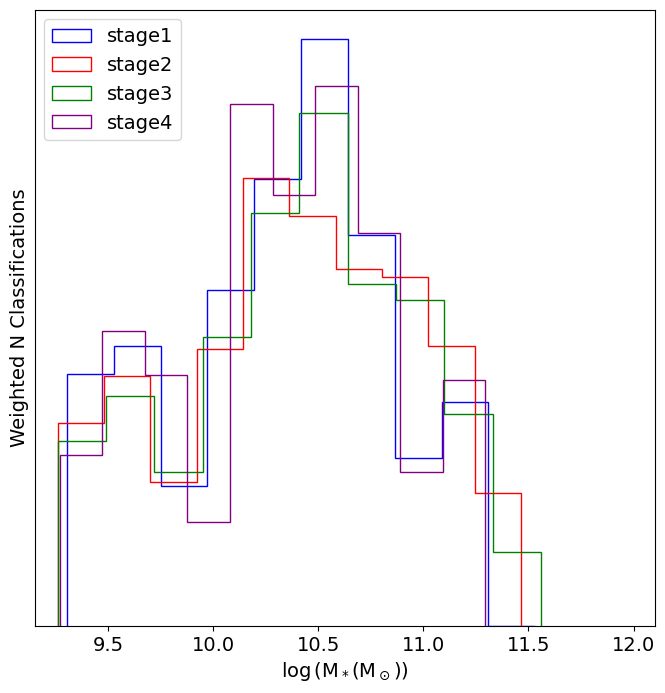

In [47]:
fig, ax = plt.subplots(figsize = (8,8))

ax.hist(sfg_s1, bins = 10, histtype='step', color='blue', weights=weights_sfg[0],density=True)
ax.hist(sfg_s2, bins = 10, histtype='step', color='red', weights=weights_sfg[1],density=True)
ax.hist(sfg_s3, bins = 10, histtype='step', color='green', weights=weights_sfg[2],density=True)
ax.hist(sfg_s4, bins = 10, histtype='step', color='purple',weights=weights_sfg[3],density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([9.15,12.1])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
# plt.savefig(f'{fig_folder}/stellar-mass-dist.pdf', bbox_inches = 'tight')
plt.show()

In [48]:
weights_agn = weight_dist([agn_s1, agn_s2, agn_s3, agn_s4], compare = 3, bins = 10, renorm = False, return_bins = False)

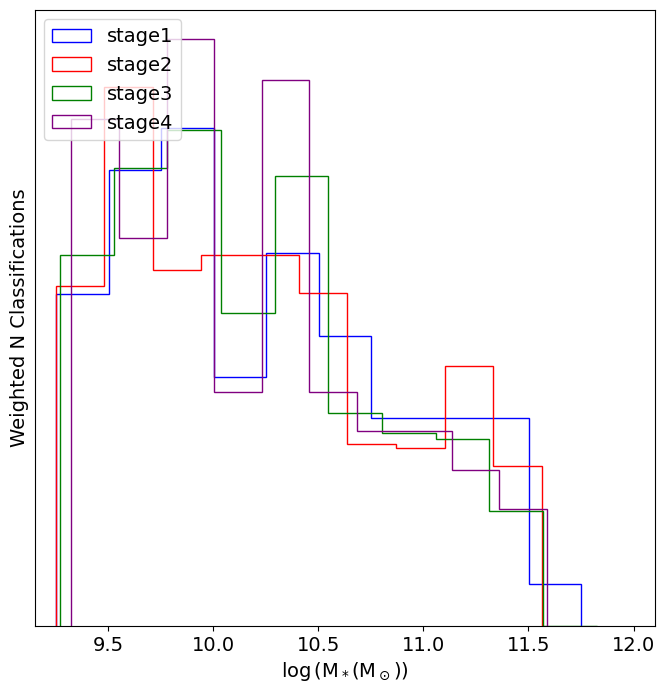

In [50]:
fig, ax = plt.subplots(figsize = (8,8))

ax.hist(agn_s1, bins = 10, histtype='step', color='blue', weights=weights_agn[0],density=True)
ax.hist(agn_s2, bins = 10, histtype='step', color='red', weights=weights_agn[1],density=True)
ax.hist(agn_s3, bins = 10, histtype='step', color='green', weights=weights_agn[2],density=True)
ax.hist(agn_s4, bins = 10, histtype='step', color='purple',weights=weights_agn[3],density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([9.15,12.1])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
# plt.savefig(f'{fig_folder}/stellar-mass-dist.pdf', bbox_inches = 'tight')
plt.show()

In [51]:
def ks_weighted(arr1_all, arr2_all, w1_all, w2_all, return_dist=False):

    '''
    Given 2 arrays and their weights, returns Kolmogorov-Smirnov statistic and significance.

    This differs from the usual K-S test in that it computes a weighted K-S statistic and
    assumes the size of each sample is equal to the sum of the weights, not the length of
    the array. It's not exactly standard statistical practice to do this, so use with 
    caution, but it doesn't seem like a completely ridiculous idea, either.

        Parameters:
            arr1_all   (array): a data sample with values to be weighted by w1_all
            arr2_all   (array): a data sample with values to be weighted by w2_all
            w1_all     (array): weights for arr1_all
            w2_all     (array): weights for arr2_all
            return_dist (bool): True if the array of all K-S distances should be returned,
                                default is False (mostly only useful for debugging)

            Note: the arrays should be np.array() but other data types based on that should
                  work too, e.g. pd.Series, Astropy Table columns, etc. -- but if you get
                  an error on those, wrap your inputs with np.array().

        Returns:
            ks:     the weighted, 2-sided K-S statistic
            p_ks:   the p-value based on the weighted K-S statistic
            sig_ks: the significance level (in sigma) assuming p-values are distributed Normally

            if return_dist == True, also:
                dist_arr: array of KS-distances in raw format (sorted by increasing data sample value)
                          seriously this is not useful statistically, it's just for debugging

    '''

    # drop dead weight
    arr1 = np.array(arr1_all[w1_all > 0.0])
    arr2 = np.array(arr2_all[w2_all > 0.0])
    w1   = np.array(  w1_all[w1_all > 0.0])
    w2   = np.array(  w2_all[w2_all > 0.0])

    # get effective lengths of the weighted arrays
    n1 = np.sum(w1)
    n2 = np.sum(w2)
 
    # this is used below in the k-s calculation
    # (weighted sample sizes)
    ct = np.sqrt((n1+n2)/(n1*n2))

    # we want to sort the arrays, and the weights
    i1 = arr1.argsort()
    i2 = arr2.argsort()

    # sort arrays and weights in increasing order
    arr1_s = np.array(arr1[i1])
    w1_s   = np.array(  w1[i1])
    arr2_s = np.array(arr2[i2])
    w2_s   = np.array(  w2[i2])

    # make combined arrays but track which element comes from what, then sort them again
    both   = np.concatenate([arr1_s, arr2_s])
    both_w = np.concatenate([  w1_s,   w2_s])
    track  = np.concatenate([np.zeros(len(arr1_s), dtype=int), np.ones(len(arr2_s), dtype=int)])

    i_both   = both.argsort()
    both_s   = np.array(  both[i_both])
    both_w_s = np.array(both_w[i_both])
    track_s  = np.array( track[i_both])

    # go through array, once, computing the distance as we go, and track the max distance between cumulative curves
    # (which are both stored in the same array)
    # both cumulative curves start at 0 so the distance starts at 0
    # also cumulative curves always increase
    the_dist = 0.0
    dist_arr = np.zeros_like(both_s)
    max_dist = 0.0
    for j, this_which in enumerate(track_s):
        # the key here is the distance between curves goes up if array A has a new value,
        # and then if B has a new value that curve increases too so the curves get closer together
        # (the distance goes down).
        # it doesn't matter which is curve A and which is curve B, just that one increments 
        # and the other decrements.
        # if we were doing a regular K-S without weights, each new value for a given array changes
        # the distance between curves by 1 count. 
        # (with weighted, it only changes the distance by that object's weight.)
        # And also, these are cumulative curves, so each curve is divided by the total counts in that array
        # (which in the weighted case means the sum of the weights)
        # as a check, the distances should start at 0 and end at 0 (because the cumulative fractional
        # histograms both start at 0.0 and end at 1.0)
        if this_which == 0:
            the_dist += both_w_s[j]/n1
        else:
            the_dist -= both_w_s[j]/n2

        dist_arr[j] = the_dist
        if np.abs(the_dist) > max_dist:
            max_dist = np.abs(the_dist) 

    # the max dist over the whole cumulative curves is the K-S distance
    ks = max_dist
    # p-value (which also cares about the sample sizes)
    p_ks   = special.kolmogorov(float(ks)/float(ct))
    # scipy.stats.ks_2samp uses this instead?
    p_ksalt   = kstwobign.sf(((1./ct) + 0.12 + (0.11 * ct)) * ks)
    #print(p_ksalt)

    # what's the significance assuming a normal distribution? (1 = 1 sigma, 2. = 2 sigma, 3. = 3 sigma result etc.)
    sig_ks = special.erfcinv(p_ks)*np.sqrt(2.)



    if return_dist:
        return ks, p_ks, sig_ks, dist_arr
    else: 
        return ks, p_ks, sig_ks

In [52]:
def weight_dist(arr1, arr2, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    w1 = np.zeros_like(arr1)
    w2 = np.zeros_like(arr2)

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to

    hist1, thebins = np.histogram(arr1, bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hist2, thebins = np.histogram(arr2, bins=thebins)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        # zero-"index"ing these because they're indices and not values
        # and if I get them mixed up below I want this to error that there's no b2 or whatever
        b0 = thebins[i_bin]
        b1 = thebins[i_bin+1]

        count1 = hist1[i_bin]
        count2 = hist2[i_bin]

        # don't miss any values and don't double-count
        if i_bin == 0:
            in_bin1 = (arr1 >= b0) & (arr1 <= b1)
            in_bin2 = (arr2 >= b0) & (arr2 <= b1)
        else: 
            in_bin1 = (arr1 >  b0) & (arr1 <= b1)
            in_bin2 = (arr2 >  b0) & (arr2 <= b1)


        # don't divide by 0 in the rest of the if/else
        if (count1 == 0) | (count2 == 0):
            w1[in_bin1] = 0.0
            w2[in_bin2] = 0.0

        elif count1 < count2:
            # weight count2 values so the sum of wt2 in this bin equals count1
            # wt_fac will always be < 1
            wt_fac = float(count1)/float(count2)
            w1[in_bin1] = 1.0
            w2[in_bin2] = wt_fac

        else:
            # weight count1 values so the sum of wt1 in this bin equals count2
            # wt_fac will always be <= 1
            wt_fac = float(count2)/float(count1)
            w1[in_bin1] = wt_fac
            w2[in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(w1) > 0.00000) & (np.amax(w1) < 1.0):
            w1 /= np.amax(w1)

        if (np.sum(w2) > 0.00000) & (np.amax(w2) < 1.0):
            w2 /= np.amax(w2)


    if return_bins:
        return w1, w2, thebins 
    else: 
        return w1, w2

In [53]:
weights_s1, weights_s2= weight_dist(agn_s1, agn_s2, bins = 20, renorm = False, return_bins = False)
weights_s1_s3, weights_s3 = weight_dist(agn_s1, agn_s3, bins = 20, renorm = False, return_bins = False)
weights_s1_s4, weights_s4 = weight_dist(agn_s1, agn_s4, bins = 20, renorm = False, return_bins = False)

In [54]:
ks_m_12, p_ks_m_12, sig_ks_12 = ks_weighted(agn_s1, agn_s2, weights_s1, weights_s2, return_dist=False)
ks_m_13, p_ks_m_13, sig_ks_13 = ks_weighted(agn_s1, agn_s3, weights_s1_s3, weights_s3, return_dist=False)
ks_m_14, p_ks_m_14, sig_ks_14 = ks_weighted(agn_s1, agn_s4, weights_s1_s4, weights_s4, return_dist=False)

In [55]:
weights_s2_s3, weights_s3 = weight_dist(agn_s2, agn_s3, bins = 20, renorm = False, return_bins = False)
weights_s2_s4, weights_s4 = weight_dist(agn_s2, agn_s4, bins = 20, renorm = False, return_bins = False)

In [56]:
ks_m_23, p_ks_m_23, sig_ks_23 = ks_weighted(agn_s2, agn_s3, weights_s2_s3, weights_s3, return_dist=False)
ks_m_24, p_ks_m_24, sig_ks_24 = ks_weighted(agn_s2, agn_s4, weights_s2_s4, weights_s4, return_dist=False)

In [57]:
weights_s3_s4, weights_s4 = weight_dist(agn_s3, agn_s4, bins = 20, renorm = False, return_bins = False)

In [58]:
ks_m_34, p_ks_m_34, sig_ks_34 = ks_weighted(agn_s3, agn_s4, weights_s3_s4, weights_s4, return_dist=False)

In [59]:
print(f'KS Score Mass between stages 1 and 2 = {ks_m_12}')
print(f'KS Score Mass between stages 1 and 3 = {ks_m_13}')
print(f'KS Score Mass between stages 1 and 4 = {ks_m_14}')
print(f'KS Score Mass between stages 2 and 3 = {ks_m_23}')
print(f'KS Score Mass between stages 2 and 4 = {ks_m_24}')
print(f'KS Score Mass between stages 3 and 4 = {ks_m_34}')
print(' ')
print(f'KS-test p-value Mass between stages 1 and 2 = {p_ks_m_12}')
print(f'KS-test p-value Mass between stages 1 and 3 = {p_ks_m_13}')
print(f'KS-test p-value Mass between stages 1 and 4 = {p_ks_m_14}')
print(f'KS-test p-value Mass between stages 2 and 3 = {p_ks_m_23}')
print(f'KS-test p-value Mass between stages 2 and 4 = {p_ks_m_24}')
print(f'KS-test p-value Mass between stages 3 and 4 = {p_ks_m_34}')
print(' ')
print(f'KS-test significance Mass between stages 1 and 2 = {sig_ks_14}')
print(f'KS-test significance Mass between stages 1 and 3 = {sig_ks_24}')
print(f'KS-test significance Mass between stages 1 and 4 = {sig_ks_34}')
print(f'KS-test significance Mass between stages 2 and 3 = {sig_ks_23}')
print(f'KS-test significance Mass between stages 2 and 4 = {sig_ks_24}')
print(f'KS-test significance Mass between stages 3 and 4 = {sig_ks_34}')

KS Score Mass between stages 1 and 2 = 0.039529914529914334
KS Score Mass between stages 1 and 3 = 0.05434782608695677
KS Score Mass between stages 1 and 4 = 0.05999999999999999
KS Score Mass between stages 2 and 3 = 0.033527696793002895
KS Score Mass between stages 2 and 4 = 0.04761904761904753
KS Score Mass between stages 3 and 4 = 0.06756756756756757
 
KS-test p-value Mass between stages 1 and 2 = 0.9999999836003894
KS-test p-value Mass between stages 1 and 3 = 0.9992253254477803
KS-test p-value Mass between stages 1 and 4 = 0.9999165616634096
KS-test p-value Mass between stages 2 and 3 = 0.9999999979986289
KS-test p-value Mass between stages 2 and 4 = 0.999998421191314
KS-test p-value Mass between stages 3 and 4 = 0.9958943881578336
 
KS-test significance Mass between stages 1 and 2 = 0.00010457444703345553
KS-test significance Mass between stages 1 and 3 = 1.9787432462930376e-06
KS-test significance Mass between stages 1 and 4 = 0.005145644071456521
KS-test significance Mass betwe

In [60]:
sfg_s1 = np.array(df_sfg.query('category == "stage1"')['ez_sfr'])
sfg_s2 = np.array(df_sfg.query('category == "stage2"')['ez_sfr'])
sfg_s3 = np.array(df_sfg.query('category == "stage3"')['ez_sfr'])
sfg_s4 = np.array(df_sfg.query('category == "stage4"')['ez_sfr'])

agn_s1 = np.array(df_agn.query('category == "stage1"')['ez_sfr'])
agn_s2 = np.array(df_agn.query('category == "stage2"')['ez_sfr'])
agn_s3 = np.array(df_agn.query('category == "stage3"')['ez_sfr'])
agn_s4 = np.array(df_agn.query('category == "stage4"')['ez_sfr'])

In [61]:
# weights_sfg = weight_dist([sfg_s1, sfg_s2, sfg_s3, sfg_s4], compare=0, bins = 10, renorm = False, return_bins = False)

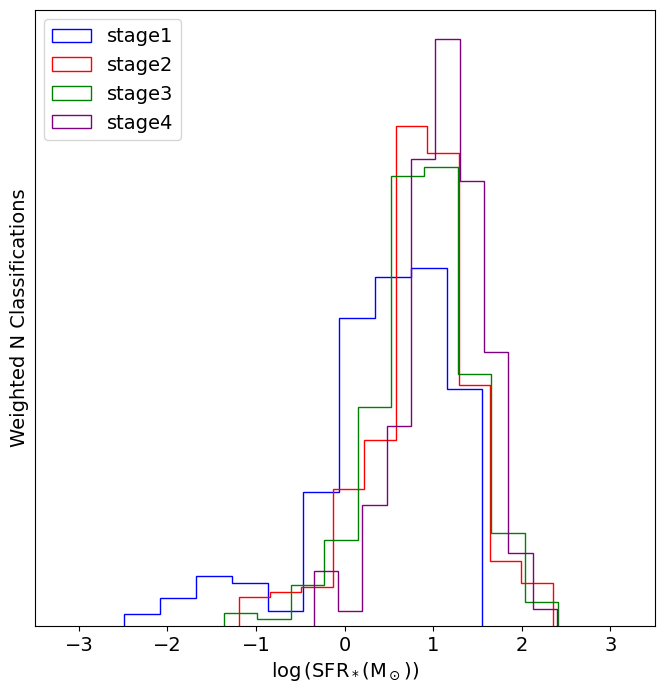

In [62]:
fig, ax = plt.subplots(figsize = (8,8))

ax.hist(sfg_s1, bins = 10, histtype='step', color='blue', weights=weights_sfg[0],density=True)
ax.hist(sfg_s2, bins = 10, histtype='step', color='red', weights=weights_sfg[1],density=True)
ax.hist(sfg_s3, bins = 10, histtype='step', color='green', weights=weights_sfg[2],density=True)
ax.hist(sfg_s4, bins = 10, histtype='step', color='purple',weights=weights_sfg[3],density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([-3.5,3.5])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$(SFR$_*$(M$_\odot$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
# plt.savefig(f'{fig_folder}/stellar-mass-dist.pdf', bbox_inches = 'tight')
plt.show()

In [63]:
# weights_agn = weight_dist([agn_s1, agn_s2, agn_s3, agn_s4], compare = 3, bins = 10, renorm = False, return_bins = False)

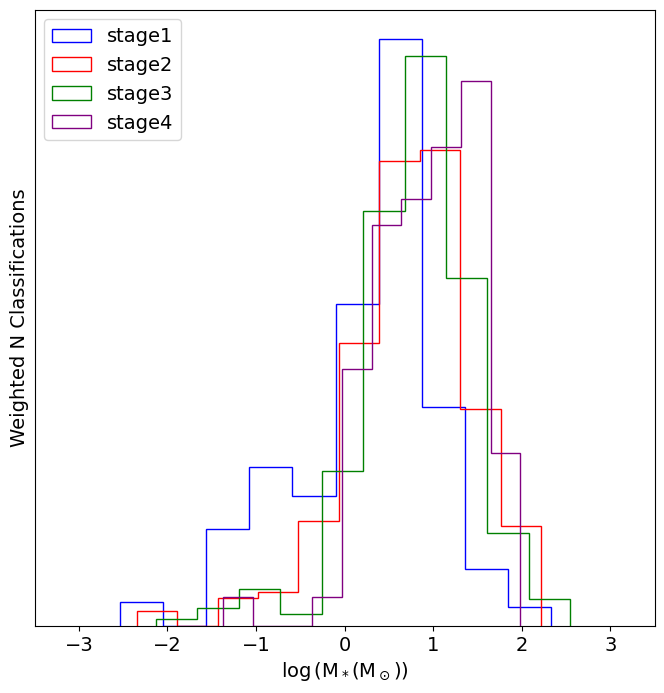

In [64]:
fig, ax = plt.subplots(figsize = (8,8))

ax.hist(agn_s1, bins = 10, histtype='step', color='blue', weights=weights_agn[0],density=True)
ax.hist(agn_s2, bins = 10, histtype='step', color='red', weights=weights_agn[1],density=True)
ax.hist(agn_s3, bins = 10, histtype='step', color='green', weights=weights_agn[2],density=True)
ax.hist(agn_s4, bins = 10, histtype='step', color='purple',weights=weights_agn[3],density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([-3.5,3.5])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
# plt.savefig(f'{fig_folder}/stellar-mass-dist.pdf', bbox_inches = 'tight')
plt.show()

### AGN Fraction

In [65]:
df_comp_agn.agn_clsf_uk.value_counts()

unknown    2218
SFG         732
AGN         454
Name: agn_clsf_uk, dtype: int64

In [66]:
agn_n_weight_s1 = np.sum(weights_agn[0] * np.ones(len(agn_s1)))
agn_n_weight_s2 = np.sum(weights_agn[1] * np.ones(len(agn_s2)))
agn_n_weight_s3 = np.sum(weights_agn[2] * np.ones(len(agn_s3)))
agn_n_weight_s4 = np.sum(weights_agn[3] * np.ones(len(agn_s4)))

In [67]:
sfg_n_weight_s1 = np.sum(weights_sfg[0] * np.ones(len(sfg_s1)))
sfg_n_weight_s2 = np.sum(weights_sfg[1] * np.ones(len(sfg_s2)))
sfg_n_weight_s3 = np.sum(weights_sfg[2] * np.ones(len(sfg_s3)))
sfg_n_weight_s4 = np.sum(weights_sfg[3] * np.ones(len(sfg_s4)))

In [68]:
unknown_n_weight_s1 = np.sum(weights_unknown[0] * np.ones(len(unknown_s1)))
unknown_n_weight_s2 = np.sum(weights_unknown[1] * np.ones(len(unknown_s2)))
unknown_n_weight_s3 = np.sum(weights_unknown[2] * np.ones(len(unknown_s3)))
unknown_n_weight_s4 = np.sum(weights_unknown[3] * np.ones(len(unknown_s4)))

In [69]:
fraction_list = []
fraction_list.append(agn_n_weight_s1 / (agn_n_weight_s1 + sfg_n_weight_s1 + unknown_n_weight_s1))
fraction_list

[0.1287313432835821]

In [70]:
fraction_list.append(agn_n_weight_s2 / (agn_n_weight_s2 + sfg_n_weight_s2 + unknown_n_weight_s2))

In [71]:
fraction_list.append(agn_n_weight_s3 / (agn_n_weight_s3 + sfg_n_weight_s3 + unknown_n_weight_s3))

In [72]:
fraction_list.append(agn_n_weight_s4 / (agn_n_weight_s4 + sfg_n_weight_s4 + unknown_n_weight_s4))

In [73]:
fraction_list

[0.1287313432835821,
 0.11609907120743033,
 0.11824817518248175,
 0.1478102189781022]

### Calculating the Errors

In [74]:
frac_successful_counts = agn_n_weight_s1# + sfg_n_weight_s1 + unknown_n_weight_s1
total_sample = len(agn_s1) #+ len(sfg_s1) + len(unknown_s1)

In [75]:
def lower_beta(c, k, n):
    return dist.beta.ppf((1-c) / 2, k+1, n-k+1)

In [76]:
def upper_beta(c,k,n):
    return dist.beta.ppf(1-(1-c)/2, k+1, n-k+1)

In [77]:
c = 0.683
k = agn_n_weight_s1
n = (agn_n_weight_s1 + sfg_n_weight_s1 + unknown_n_weight_s1)

In [78]:
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c, k, n)

In [79]:
upper_p

0.14460460135267142

In [80]:
lower_p

0.11562083276974483

In [81]:
error_list = []
c = 0.683

k = agn_n_weight_s1
n = (agn_n_weight_s1 + sfg_n_weight_s1 + unknown_n_weight_s1)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[0] - lower_p, upper_p - fraction_list[0]])

k = agn_n_weight_s2
n = (agn_n_weight_s2 + sfg_n_weight_s2 + unknown_n_weight_s2)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[1] - lower_p, upper_p - fraction_list[1]])

k = agn_n_weight_s3
n = (agn_n_weight_s3 + sfg_n_weight_s3 + unknown_n_weight_s3)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[2] - lower_p, upper_p - fraction_list[2]])

k = agn_n_weight_s4
n = (agn_n_weight_s4 + sfg_n_weight_s4 + unknown_n_weight_s4)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[3] - lower_p, upper_p - fraction_list[3]])

In [82]:
error_array = np.asarray(error_list).T

In [83]:
x = ['Separated', 'Pericentre', 'Apocentre','Merging']

In [84]:
fraction_list

[0.1287313432835821,
 0.11609907120743033,
 0.11824817518248175,
 0.1478102189781022]

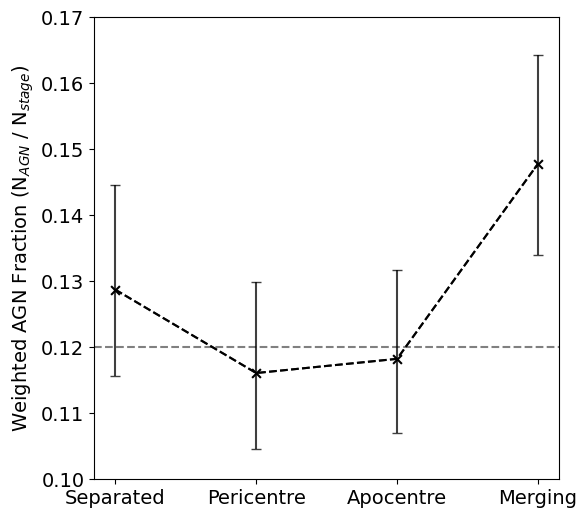

In [307]:
plt.figure(figsize = (6,6))
plt.axhline(0.12, color = 'gray', linestyle = '--')
plt.scatter(x, fraction_list, color = 'black', s = 40, marker = 'x')
plt.errorbar(x, fraction_list, color = 'black', yerr = error_array, alpha = 0.75, linestyle = '--', capsize = 3.5)
plt.plot(x, fraction_list, color='black', linestyle='--')
plt.ylabel('Weighted AGN Fraction (N$_{AGN}$ / N$_{stage}$)')
plt.ylim([0.10,0.17])
plt.savefig(f'{fig_folder}/agn-frac-time.pdf', bbox_inches = 'tight')
plt.show()

Do see a general increase in the AGN fraction with stage, although stage 1 is way too high. Will need to look into on Sunday.

In [86]:
fraction_list

[0.1287313432835821,
 0.11609907120743033,
 0.11824817518248175,
 0.1478102189781022]

In [87]:
df_comp_agn.query('category == "stage1"').agn_clsf_uk.value_counts()

unknown    502
SFG        112
AGN        101
Name: agn_clsf_uk, dtype: int64

In [88]:
df_comp_agn.query('category == "stage2"').agn_clsf_uk.value_counts()

unknown    532
SFG        169
AGN        108
Name: agn_clsf_uk, dtype: int64

In [89]:
df_comp_agn.query('category == "stage3"').agn_clsf_uk.value_counts()

unknown    815
SFG        283
AGN        161
Name: agn_clsf_uk, dtype: int64

In [90]:
df_comp_agn.query('category == "stage4"').agn_clsf_uk.value_counts()

unknown    369
SFG        168
AGN         84
Name: agn_clsf_uk, dtype: int64

## AGN With Pairs

In [91]:
df_comp_agn.head()

,ID,category,ez_sfr,lp_mass_best,redshift,ms_sfr,sfr_sfr_ms,agn_clsf_uk
0,816891,stage4,0.589695,9.28590,0.519525,-0.006678,0.596373,unknown
1,860686,stage3,1.609304,10.44862,1.124400,1.306298,0.303006,unknown
2,1304538,stage3,1.101499,9.96798,1.024009,0.878992,0.222507,unknown
3,1310001,stage3,1.083541,10.41827,0.486400,0.825686,0.257855,unknown
4,1308927,stage3,1.198906,10.03523,0.695800,0.703430,0.495476,unknown


In [92]:
df_pairs = pd.read_csv(f'{combine_fold}/primary-secondary-z-checked.csv', index_col = 0)

In [93]:
def calc_seps(prim_ra, prim_dec, sec_ra, sec_dec, z1, z2, cosmo):
    z = (z1 + z2) / 2
    
    prim_coord = SkyCoord(ra = prim_ra * u.deg, dec = prim_dec * u.deg, frame = 'fk5')
    sec_coord = SkyCoord(ra = sec_ra * u.deg, dec = sec_dec * u.deg, frame = 'fk5')
    
    sep = (prim_coord.separation(sec_coord)).to(u.arcmin)
    
    conversion = cosmo.kpc_proper_per_arcmin(z)
    
    proj_dist = (sep * conversion) / u.kpc
    
    return proj_dist

In [94]:
cosmo = FlatLambdaCDM(H0=70.0 * u.km / (u.Mpc * u.s), Om0=0.3, Tcmb0=2.725 * u.K)

In [95]:
df_projs = df_pairs.assign(proj_seps = df_pairs.apply(lambda row: calc_seps(row.Prim_RA, row.Prim_Dec, row.Sec_RA, row.Sec_Dec, row.z_prim, row.z_sec, cosmo), axis = 1))

In [96]:
df_prim = df_projs[['ORyan23_ID_1', 'ID_Prim', 'prim_cat', 'proj_seps']]
df_sec = df_projs[['ORyan23_ID_2', 'ID_Sec', 'sec_cat', 'proj_seps']]

In [97]:
df_prim_merge = (
    df_prim
    .merge(df_comp_agn[['ID', 'agn_clsf_uk']], left_on = 'ID_Prim', right_on = 'ID')
)

In [98]:
df_prim_merge.agn_clsf_uk.value_counts()

unknown    221
SFG         63
AGN         41
Name: agn_clsf_uk, dtype: int64

In [99]:
df_sec_merge = (
    df_sec
    .merge(df_comp_agn[['ID', 'agn_clsf_uk']], left_on = 'ID_Sec', right_on = 'ID')
)

In [100]:
df_sec_merge.agn_clsf_uk.value_counts()

unknown    216
SFG         63
AGN         46
Name: agn_clsf_uk, dtype: int64

In [101]:
df_sec_merge.head()

,ORyan23_ID_2,ID_Sec,sec_cat,proj_seps,ID,agn_clsf_uk
0,4000705547180,1264241,stage1,75.6709695405294,1264241,SFG
1,4000706649921,844303,stage3,93.82062595743643,844303,AGN
2,4000707047768,246327,stage1,36.84827401550911,246327,unknown
3,4000711650343,1084532,stage3,62.400421019337664,1084532,unknown
4,4000711823990,1458688,stage1,107.35544736235751,1458688,AGN


In [102]:
df_agn_clsf_merged = (
    df_prim_merge
    .merge(df_sec_merge, left_on = 'ORyan23_ID_1', right_on = 'ORyan23_ID_2', how = 'left')
)

In [103]:
df_agn_clsf_merged

,ORyan23_ID_1,ID_Prim,prim_cat,proj_seps_x,ID_x,agn_clsf_uk_x,ORyan23_ID_2,ID_Sec,sec_cat,proj_seps_y,ID_y,agn_clsf_uk_y
0,4000705547180,1266054,stage1,75.6709695405294,1266054,SFG,4000705547180,1264241,stage1,75.6709695405294,1264241,SFG
1,4000706649921,840582,stage3,93.82062595743643,840582,unknown,4000706649921,844303,stage3,93.82062595743643,844303,AGN
2,4000707047768,246358,stage1,36.84827401550911,246358,unknown,4000707047768,246327,stage1,36.84827401550911,246327,unknown
3,4000711650343,1082084,stage3,62.400421019337664,1082084,unknown,4000711650343,1084532,stage3,62.400421019337664,1084532,unknown
4,4000711823990,1456134,stage1,107.35544736235751,1456134,SFG,4000711823990,1458688,stage1,107.35544736235751,1458688,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...
320,4000853484788,547351,stage2,14.113411268206328,547351,unknown,4000853484788,547702,stage2,14.113411268206328,547702,unknown
321,4000854480186,917157,stage3,33.994231601273654,917157,unknown,4000854480186,917450,stage3,33.994231601273654,917450,unknown
322,4000859156914,793415,stage3,20.020331370161777,793415,unknown,4000859156914,791176,stage3,20.020331370161777,791176,unknown
323,4000859744431,1395467,stage3,34.639346496588566,1395467,unknown,4000859744431,1395057,stage3,34.639346496588566,1395057,unknown


(0.0, 150.0)

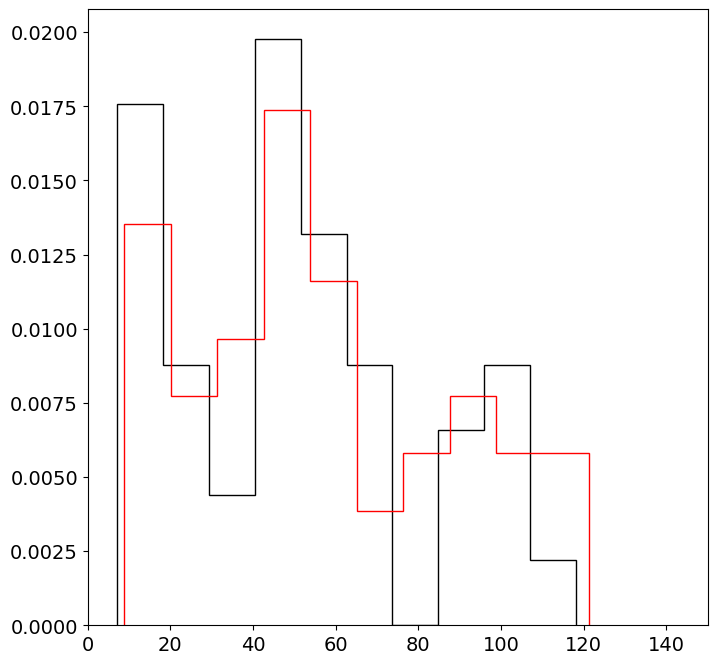

In [104]:
fig, ax = plt.subplots(figsize = (8,8))
agn_proj_prim = list(df_agn_clsf_merged.query('agn_clsf_uk_x == "AGN"').proj_seps_x)
agn_proj_sec = list(df_agn_clsf_merged.query('agn_clsf_uk_y == "AGN"').proj_seps_y)

ax.hist(agn_proj_prim, bins = 10, histtype='step', color = 'black', density = True)
ax.hist(agn_proj_sec, bins = 10, histtype='step', color='red', density = True)
ax.set_xlim([0,150])

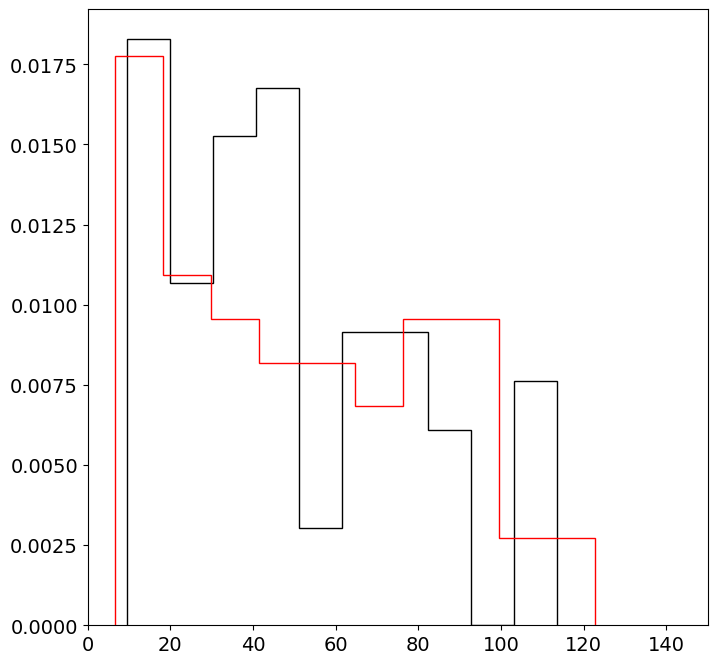

In [105]:
fig, ax = plt.subplots(figsize = (8,8))
sfg_proj_prim = list(df_agn_clsf_merged.query('agn_clsf_uk_x == "SFG"').proj_seps_x)
sfg_proj_sec = list(df_agn_clsf_merged.query('agn_clsf_uk_y == "SFG"').proj_seps_y)

ax.hist(sfg_proj_prim, bins = 10, histtype='step', color = 'black', density=True)
ax.hist(sfg_proj_sec, bins = 10, histtype='step', color='red', density = True)
ax.set_xlim([0,150])
plt.show()

In [106]:
agn_comb = agn_proj_prim.copy()
for i in agn_proj_sec:
    agn_comb.append(i)
    
sfg_comb = sfg_proj_prim.copy()
for i in sfg_proj_sec:
    sfg_comb.append(i)

In [107]:
print(len(agn_comb))
print(len(sfg_comb))

87
126


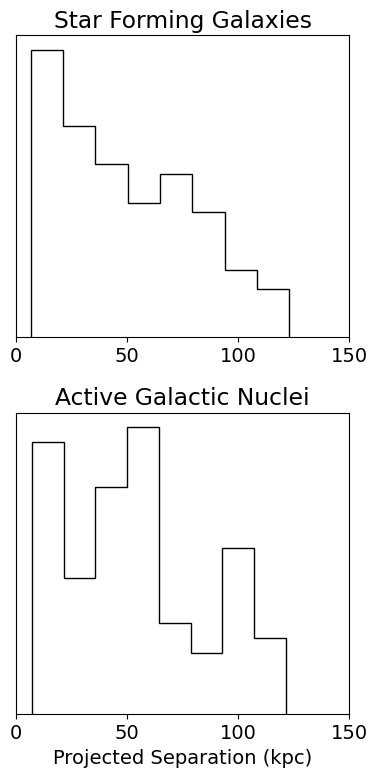

In [278]:
fig, ax = plt.subplots(nrows = 2, figsize = (4,8))

ax[0].hist(sfg_comb, bins = 8, histtype='step', color = 'black', density=True)
ax[1].hist(agn_comb, bins = 8, histtype='step', color='black', density = True)
ax[0].set_xlim([0,150])
ax[0].tick_params(left = False, labelleft=False)
ax[1].tick_params(left = False, labelleft=False)
ax[1].set_xlim([0,150])
ax[0].set_title('Star Forming Galaxies')
ax[1].set_title('Active Galactic Nuclei')
ax[1].set_xlabel('Projected Separation (kpc)')
fig.tight_layout()
# fig.savefig(f'{fig_folder}/sfg-agn-dist.pdf', bbox_inches='tight')
plt.show()

## Plotting AGN Fraction with Projected Separation

In [109]:
df_prim_agn = df_prim_merge.query('agn_clsf_uk == "AGN"').rename(columns = {'prim_cat': 'cat'})
df_sec_agn = df_sec_merge.query('agn_clsf_uk == "AGN"').rename(columns = {'sec_cat':'cat'})
df_proj_agn = pd.concat([df_prim_agn, df_sec_agn])[['ID', 'proj_seps', 'cat']]
df_proj_agn

,ID,proj_seps,cat
6,905466,7.163352652679144,stage2
11,1404585,19.270951143556587,stage2
14,757772,34.08366606651514,stage2
16,484137,42.915546117101975,stage3
35,566893,46.572883073245066,stage1
...,...,...,...
283,513538,8.87891460492783,stage2
296,473524,53.509897274501235,stage3
302,641312,36.0655167009546,stage3
305,1160048,30.24708755082214,stage1


In [110]:
df_prim_sfg = df_prim_merge.query('agn_clsf_uk == "SFG"').rename(columns = {'prim_cat': 'cat'})
df_sec_sfg = df_sec_merge.query('agn_clsf_uk == "SFG"').rename(columns = {'sec_cat':'cat'})
df_proj_sfg = pd.concat([df_prim_sfg, df_sec_sfg])[['ID', 'proj_seps', 'cat']]
df_proj_sfg

,ID,proj_seps,cat
0,1266054,75.6709695405294,stage1
4,1456134,107.35544736235751,stage1
10,660506,32.74358707590767,stage1
17,556275,42.04404215036861,stage1
19,338686,46.01445313748683,stage1
...,...,...,...
286,935549,42.94741637596922,stage3
289,1101476,63.72391592566724,stage1
291,1197756,60.277581236155605,stage3
310,368071,65.16606067366833,stage3


In [111]:
df_all = pd.concat([df_prim_merge.rename(columns = {'prim_cat': 'cat'}), df_sec_merge.rename(columns = {'sec_cat':'cat'})])[['ID', 'proj_seps', 'cat']]
df_all

,ID,proj_seps,cat
0,1266054,75.6709695405294,stage1
1,840582,93.82062595743643,stage3
2,246358,36.84827401550911,stage1
3,1082084,62.400421019337664,stage3
4,1456134,107.35544736235751,stage1
...,...,...,...
320,547702,14.113411268206328,stage2
321,917450,33.994231601273654,stage3
322,791176,20.020331370161777,stage3
323,1395057,34.639346496588566,stage3


In [112]:
nbins = 20
bins = np.linspace(0,200, nbins)
agn_bins = np.zeros(nbins)
sfg_bins = np.zeros(nbins)
weight_bins = np.zeros(nbins)

In [113]:
for i in range(len(bins)-1):
    max_d = bins[i+1]
    min_d = bins[i]
    
    agn_bins[i] = len(df_proj_agn.query('proj_seps >= @min_d and proj_seps < @max_d'))
    sfg_bins[i] = len(df_proj_sfg.query('proj_seps >= @min_d and proj_seps < @max_d'))
    weight_bins[i] = (agn_bins[i] + sfg_bins[i]) / len(df_all.query('proj_seps >= @min_d and proj_seps < @max_d'))

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [114]:
print(agn_bins)
print(sfg_bins)

[ 2. 15.  6.  7. 16. 14.  6.  1.  6.  9.  3.  2.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 3. 27. 12. 16. 16.  9.  9. 14.  8.  5.  5.  2.  0.  0.  0.  0.  0.  0.
  0.  0.]


In [115]:
weight_bins

array([0.20833333, 0.328125  , 0.27272727, 0.25555556, 0.3902439 ,
       0.33823529, 0.24193548, 0.32608696, 0.41176471, 0.53846154,
       0.66666667, 0.5       , 0.        ,        nan,        nan,
              nan,        nan, 0.        ,        nan, 0.        ])

In [116]:
agn_bins[agn_bins < 5] = np.nan
sfg_bins[sfg_bins < 10] = np.nan

In [117]:
frac_bins = weight_bins * (agn_bins / sfg_bins)

In [118]:
frac_bins

array([       nan, 0.18229167, 0.13636364, 0.11180556, 0.3902439 ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

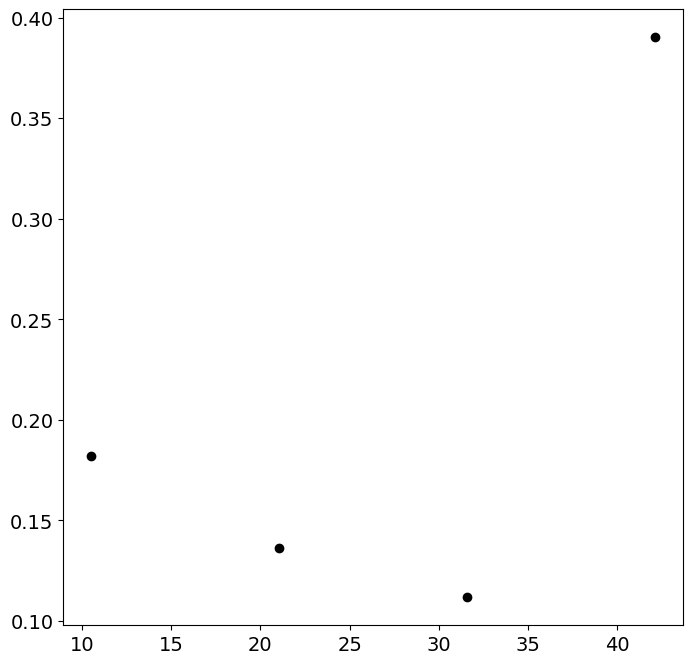

In [119]:
plt.figure(figsize = (8,8))
plt.scatter(bins, frac_bins, color = 'black')
plt.show()

## Looking at Stage

In [120]:
df_proj_sfg

,ID,proj_seps,cat
0,1266054,75.6709695405294,stage1
4,1456134,107.35544736235751,stage1
10,660506,32.74358707590767,stage1
17,556275,42.04404215036861,stage1
19,338686,46.01445313748683,stage1
...,...,...,...
286,935549,42.94741637596922,stage3
289,1101476,63.72391592566724,stage1
291,1197756,60.277581236155605,stage3
310,368071,65.16606067366833,stage3


In [121]:
df_proj_agn.query('cat == "stage4"')

,ID,proj_seps,cat
254,1026253,12.813024144713234,stage4


In [274]:
bins = np.linspace(0,100,8)

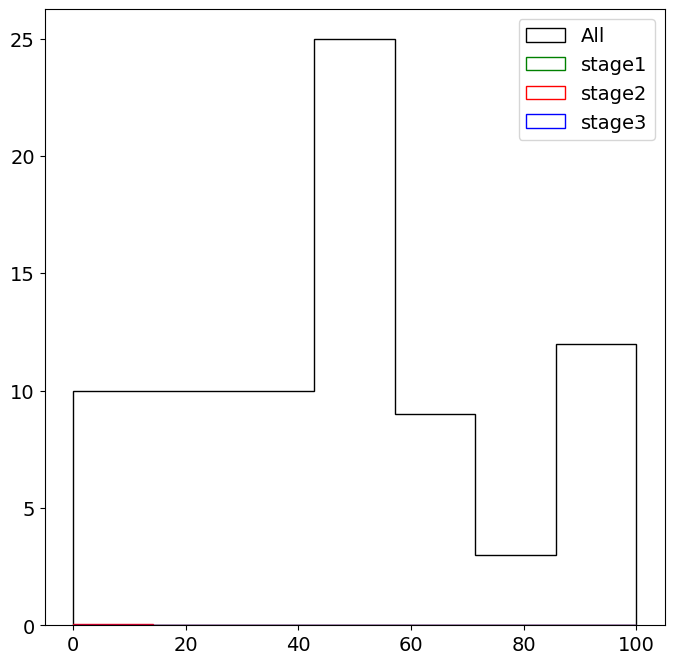

In [275]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(list(df_proj_agn.proj_seps), bins = bins, histtype='step', color='black')
ax.hist(list(df_proj_agn.query('cat == "stage1"').proj_seps), bins = bins, histtype='step', color='green', density = True)
ax.hist(list(df_proj_agn.query('cat == "stage2"').proj_seps), bins = bins, histtype='step', color='red', density = True)
ax.hist(list(df_proj_agn.query('cat == "stage3"').proj_seps), bins = bins, histtype='step', color='blue', density = True)
# ax.hist(list(df_proj_agn.query('cat == "stage4"').proj_seps), bins = bins, histtype='step', color='black', density = True)
plt.legend(['All','stage1','stage2','stage3'])
plt.show()

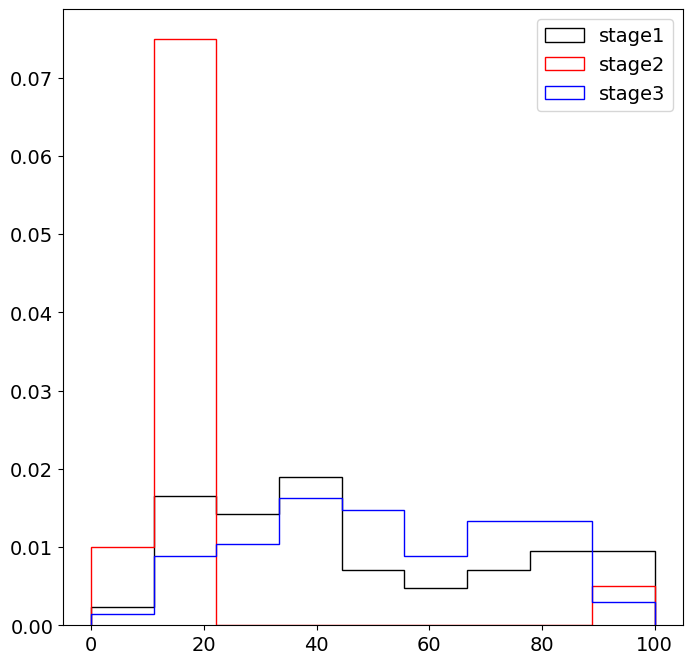

In [124]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(list(df_proj_sfg.query('cat == "stage1"').proj_seps), bins = bins, histtype='step', color='black', density = True)
ax.hist(list(df_proj_sfg.query('cat == "stage2"').proj_seps), bins = bins, histtype='step', color='red', density = True)
ax.hist(list(df_proj_sfg.query('cat == "stage3"').proj_seps), bins = bins, histtype='step', color='blue', density = True)
# ax.hist(list(df_proj_agn.query('cat == "stage4"').proj_seps), bins = bins, histtype='step', color='black', density = True)
plt.legend(['stage1','stage2','stage3'])
plt.show()

### Doing Above Properly!

In [137]:
df_agn_merged_red = df_agn_clsf_merged[['ID_Prim', 'prim_cat', 'proj_seps_x', 'agn_clsf_uk_x', 'ID_Sec', 'sec_cat', 'agn_clsf_uk_y']]
df_agn_merged_red

,ID_Prim,prim_cat,proj_seps_x,agn_clsf_uk_x,ID_Sec,sec_cat,agn_clsf_uk_y
0,1266054,stage1,75.6709695405294,SFG,1264241,stage1,SFG
1,840582,stage3,93.82062595743643,unknown,844303,stage3,AGN
2,246358,stage1,36.84827401550911,unknown,246327,stage1,unknown
3,1082084,stage3,62.400421019337664,unknown,1084532,stage3,unknown
4,1456134,stage1,107.35544736235751,SFG,1458688,stage1,AGN
...,...,...,...,...,...,...,...
320,547351,stage2,14.113411268206328,unknown,547702,stage2,unknown
321,917157,stage3,33.994231601273654,unknown,917450,stage3,unknown
322,793415,stage3,20.020331370161777,unknown,791176,stage3,unknown
323,1395467,stage3,34.639346496588566,unknown,1395057,stage3,unknown


In [139]:
df_agn_clsf_prim = df_agn_merged_red[['ID_Prim', 'prim_cat', 'proj_seps_x', 'agn_clsf_uk_x']].rename(columns = {'ID_Prim':'ID', 'prim_cat' : 'cat', 'proj_seps_x' : 'proj_seps', 'agn_clsf_uk_x' : 'agn_clsf_uk'})
df_agn_clsf_sec = df_agn_merged_red[['ID_Sec', 'sec_cat', 'proj_seps_x', 'agn_clsf_uk_y']].rename(columns = {'ID_Sec':'ID', 'sec_cat' : 'cat', 'proj_seps_x' : 'proj_seps', 'agn_clsf_uk_y' : 'agn_clsf_uk'})
df_double_sample = pd.concat([df_agn_clsf_prim, df_agn_clsf_sec])
df_double_sample

,ID,cat,proj_seps,agn_clsf_uk
0,1266054,stage1,75.6709695405294,SFG
1,840582,stage3,93.82062595743643,unknown
2,246358,stage1,36.84827401550911,unknown
3,1082084,stage3,62.400421019337664,unknown
4,1456134,stage1,107.35544736235751,SFG
...,...,...,...,...
320,547702,stage2,14.113411268206328,unknown
321,917450,stage3,33.994231601273654,unknown
322,791176,stage3,20.020331370161777,unknown
323,1395057,stage3,34.639346496588566,unknown


In [247]:
sfg_proj_s1 = list(df_double_sample.query('cat == "stage1" & agn_clsf_uk == "SFG"').proj_seps.astype(float))
sfg_proj_s2 = list(df_double_sample.query('cat == "stage2" & agn_clsf_uk == "SFG"').proj_seps.astype(float))
sfg_proj_s3 = list(df_double_sample.query('cat == "stage3" & agn_clsf_uk == "SFG"').proj_seps.astype(float))

sfg_all = list(df_double_sample.query('agn_clsf_uk == "SFG"').proj_seps.astype(float))

agn_proj_s1 = list(df_double_sample.query('cat == "stage1" & agn_clsf_uk == "AGN"').proj_seps.astype(float))
agn_proj_s2 = list(df_double_sample.query('cat == "stage2" & agn_clsf_uk == "AGN"').proj_seps.astype(float))
agn_proj_s3 = list(df_double_sample.query('cat == "stage3" & agn_clsf_uk == "AGN"').proj_seps.astype(float))

agn_all = list(df_double_sample.query('agn_clsf_uk == "AGN"').proj_seps.astype(float))

In [217]:
def weight_dist(arrs, min_int, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to
    hists = []
    hist1, thebins = np.histogram(arrs[0], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hists.append(hist1)
    for i in arrs[1:]:
        hist_tmp, thebins = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        for i_hist in range(len(hists)-1):
            # zero-"index"ing these because they're indices and not values
            # and if I get them mixed up below I want this to error that there's no b2 or whatever
            b0 = thebins[i_bin]
            b1 = thebins[i_bin+1]

            count1 = hists[min_int][i_bin]
            count2 = hists[i_hist][i_bin]

            # don't miss any values and don't double-count
            if i_bin == 0:
                in_bin1 = (arrs[min_int] >= b0) & (arrs[min_int] <= b1)
                in_bin2 = (arrs[i_hist] >= b0) & (arrs[i_hist] <= b1)
            else: 
                in_bin1 = (arrs[min_int] >  b0) & (arrs[min_int] <= b1)
                in_bin2 = (arrs[i_hist] >  b0) & (arrs[i_hist] <= b1)


            # don't divide by 0 in the rest of the if/else
            if (count1 == 0) | (count2 == 0):
                ws_list[min_int][in_bin1] = 0.0
                ws_list[i_hist][in_bin2] = 0.0

            elif count1 < count2:
                # weight count2 values so the sum of wt2 in this bin equals count1
                # wt_fac will always be < 1
                wt_fac = float(count1)/float(count2)
                ws_list[min_int][in_bin1] = 1.0
                ws_list[i_hist][in_bin2] = wt_fac

            else:
                # weight count1 values so the sum of wt1 in this bin equals count2
                # wt_fac will always be <= 1
                wt_fac = float(count2)/float(count1)
                ws_list[min_int][in_bin1] = wt_fac
                ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws, thebins 
    else: 
        return ws_list

In [287]:
weights_sfg = weight_dist([sfg_proj_s1, sfg_proj_s2, sfg_proj_s3], 0, bins = 8, renorm = False, return_bins = False)
weights_agn = weight_dist([agn_proj_s1, agn_proj_s2, agn_proj_s3], 0, bins = 8, renorm = False, return_bins = False)

In [288]:
sfgs = [sfg_proj_s1, sfg_proj_s2, sfg_proj_s3]
agns = [agn_proj_s1, agn_proj_s2, agn_proj_s3]

In [289]:
def lower_beta(c,k,n):
    return dist.beta.ppf((1-c)/2, k+1, n-k+1)

In [290]:
def upper_beta(c,k,n):
    return dist.beta.ppf(1-(1-c)/2, k+1, n-k+1)

In [291]:
p_sfg = [[],[],[],[]]
for counter, i in enumerate(weights_sfg):
    # Getting Weighted Masses
    sfg = sfgs[counter]    
    
    _, bins = np.histogram(sfg, bins=8)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(sfg > lower_bin) & (sfg <= upper_bin)][0].astype(bool)
        
        weights_bin = weights_sfg[counter][mask]
        sfg_bin = np.asarray(sfg)[mask]
        
        counts = np.ones(len(sfg_bin))
        counts = np.sum(weights_bin * counts)
        
        upper_p = upper_beta(0.683, counts, len(sfg))
        lower_p = lower_beta(0.683, counts, len(sfg))
                    
        if counts == 0:
            p_sfg[counter].append([0,0])
        else:
            p_sfg[counter].append([((counts / len(sfg)) - lower_p),  (upper_p - (counts / len(sfg)))])

In [292]:
colours = ['blue', 'red', 'orange']
linestyles = ['dotted','dashed','dashdot']

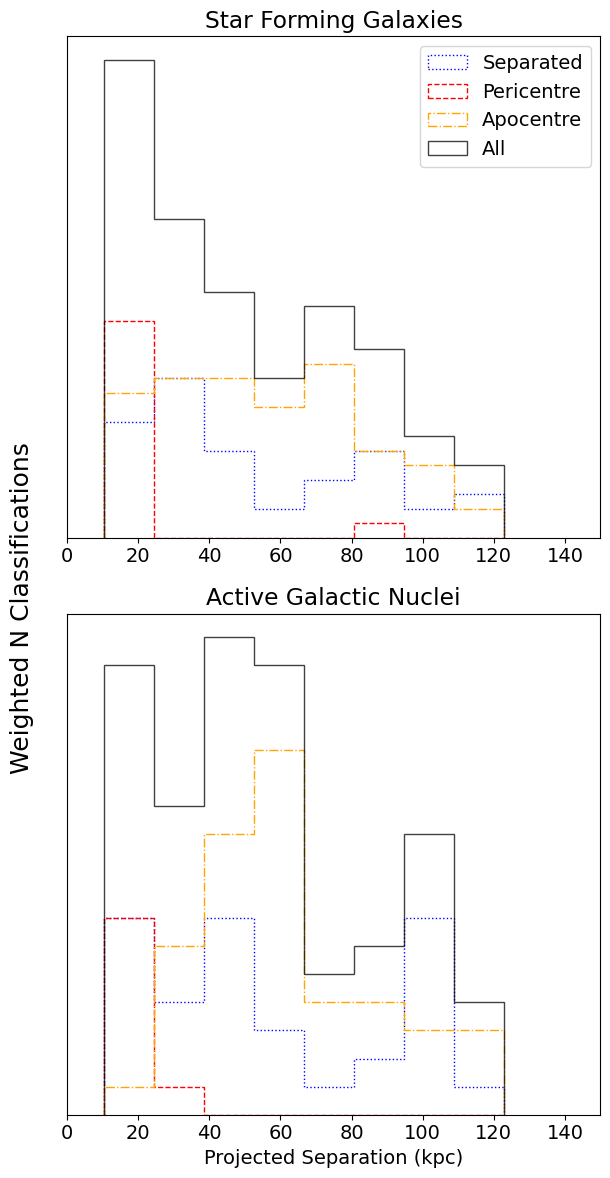

In [305]:
fig, ax = plt.subplots(nrows = 2, figsize = (6,12))
for i in range(3):
    ax[0].hist(sfgs[i], bins = bins, histtype='step', color=colours[i], linestyle = linestyles[i], weights = np.ones(len(sfgs[i])) / len(sfg_all))
    ax[1].hist(agns[i], bins = bins, histtype='step', color=colours[i], linestyle = linestyles[i], weights = np.ones(len(agns[i])) / len(agn_all))
    
ax[0].hist(sfg_all, bins = bins, histtype='step', color = 'black', weights = np.ones(len(sfg_all)) / len(sfg_all), alpha = 0.75)
ax[1].hist(agn_all, bins = bins, histtype='step', color = 'black', weights = np.ones(len(agn_all)) / len(agn_all), alpha = 0.75)
    
ax[0].legend(['Separated', 'Pericentre', 'Apocentre', 'All'], loc = 'upper right')
fig.text(-0.05, 0.35, 'Weighted N Classifications', rotation = 'vertical', fontsize = 18)
ax[0].set_xlim([0,150])
ax[0].tick_params(left = False, labelleft=False)
ax[1].tick_params(left = False, labelleft=False)
ax[1].set_xlim([0,150])
ax[0].set_title('Star Forming Galaxies')
ax[1].set_title('Active Galactic Nuclei')
ax[1].set_xlabel('Projected Separation (kpc)')
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfg-agn-dist.pdf', bbox_inches='tight', dpi = 500)